# Namų darbas 3

https://www.tradingview.com/chart/aq2kGdef/?symbol=NASDAQ%3AMETA


In [13]:
import yfinance as yf
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid", palette="viridis")

date_min = datetime.date(2022, 10, 1)
date_max = datetime.date(2023, 10, 1)

symbol = "META"
stock = yf.Ticker(symbol)
hist = stock.history(
    start=date_min.strftime("%Y-%m-%d"), end=date_max.strftime("%Y-%m-%d")
)
close_prices = hist["Close"]
open_prices = hist["Open"]
shifted_close_prices = close_prices.shift()
shifted_open_prices = open_prices.shift()

## EMA

The exponential moving average (EMA) is a technical chart indicator that tracks the price of an investment (like a stock or commodity) over time. The EMA is a type of weighted moving average (WMA) that gives more weighting or importance to recent price data. Like the simple moving average (SMA), the EMA is used to see price trends over time, and watching several EMAs at the same time is easy to do with moving average ribbons.

https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp


In [14]:
def calculate_ema(prices, period=14):
    alpha = 2 / (period + 1)
    ema = [prices.iloc[0]]
    for price in prices[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])
    return pd.Series(ema, index=prices.index)

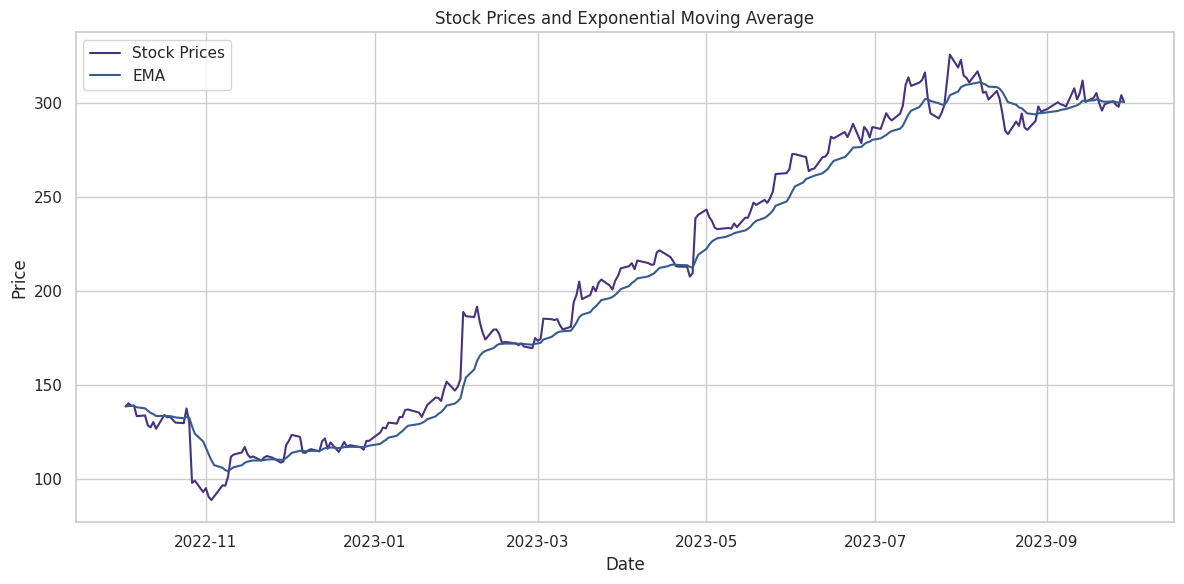

In [15]:
ema_values = calculate_ema(close_prices)

plt.figure(figsize=(12, 6))

sns.lineplot(data=close_prices, label="Stock Prices")
sns.lineplot(data=ema_values, label="EMA")

plt.title("Stock Prices and Exponential Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

## MACD

The moving average convergence divergence indicator helps traders see the trend direction, as well as the momentum of that trend. It also provides a number of trade signals. When the MACD is above zero, the price is in an upward phase. If the MACD is below zero, it has entered a bearish period.

The indicator is composed of two lines: the MACD line and a signal line, which moves slower. When MACD crosses below the signal line, it indicates that the price is falling. When the MACD line crosses above the signal line, the price is rising.

Looking at which side of zero the indicator is on aids in determining which signals to follow. For example, if the indicator is above zero, watch for the MACD to cross above the signal line to buy. If the MACD is below zero, the MACD crossing below the signal line may provide the signal for a possible short trade.

https://www.investopedia.com/top-7-technical-analysis-tools-4773275


In [16]:
def calculate_macd(price_series, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = calculate_ema(price_series, period=fast_period)
    slow_ema = calculate_ema(price_series, period=slow_period)

    macd_line = fast_ema - slow_ema
    signal_line = calculate_ema(macd_line, period=signal_period)
    macd_histogram = macd_line - signal_line

    macd_df = pd.DataFrame(index=price_series.index)
    macd_df["MACD_Line"] = macd_line
    macd_df["Signal_Line"] = signal_line
    macd_df["MACD_Histogram"] = macd_histogram

    return macd_df

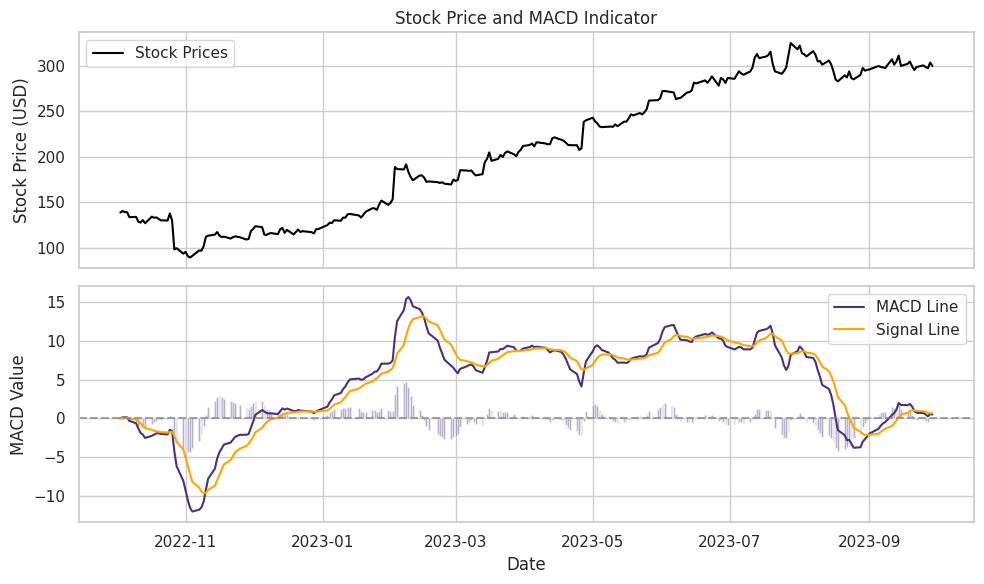

In [17]:
macd_result = calculate_macd(close_prices)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6), sharex=True)

sns.lineplot(ax=ax1, data=close_prices, label="Stock Prices", color="black")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (USD)")

ax1.set_title("Stock Price and MACD Indicator")

sns.lineplot(ax=ax2, data=macd_result["MACD_Line"], label="MACD Line")
sns.lineplot(
    ax=ax2, data=macd_result["Signal_Line"], label="Signal Line", color="orange"
)

ax2.bar(
    macd_result.index, macd_result["MACD_Histogram"], label="MACD Histogram", alpha=0.5
)
ax2.axhline(0, linestyle="--", alpha=0.7, color="grey")

ax2.set_xlabel("Date")
ax2.set_ylabel("MACD Value")

plt.tight_layout()
plt.show()

## RSI

The relative strength index has at least three major uses. The indicator moves between zero and 100, plotting recent price gains versus recent price losses. The RSI levels therefore help in gauging momentum and trend strength.

The most basic use of an RSI is as an overbought and oversold indicator. When the RSI moves above 70, the asset is considered overbought and could decline. When the RSI is below 30, the asset is oversold and could rally.

https://www.investopedia.com/top-7-technical-analysis-tools-4773275


In [18]:
def calculate_rsi(series, period=14):
    delta = series.diff()

    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # ema of gains and losses
    average_gain = gain.ewm(alpha=1.0 / period, min_periods=period, adjust=False).mean()
    average_loss = loss.ewm(alpha=1.0 / period, min_periods=period, adjust=False).mean()

    # relative strength
    rs = average_gain / average_loss

    rsi = 100 - (100 / (1 + rs))
    return rsi

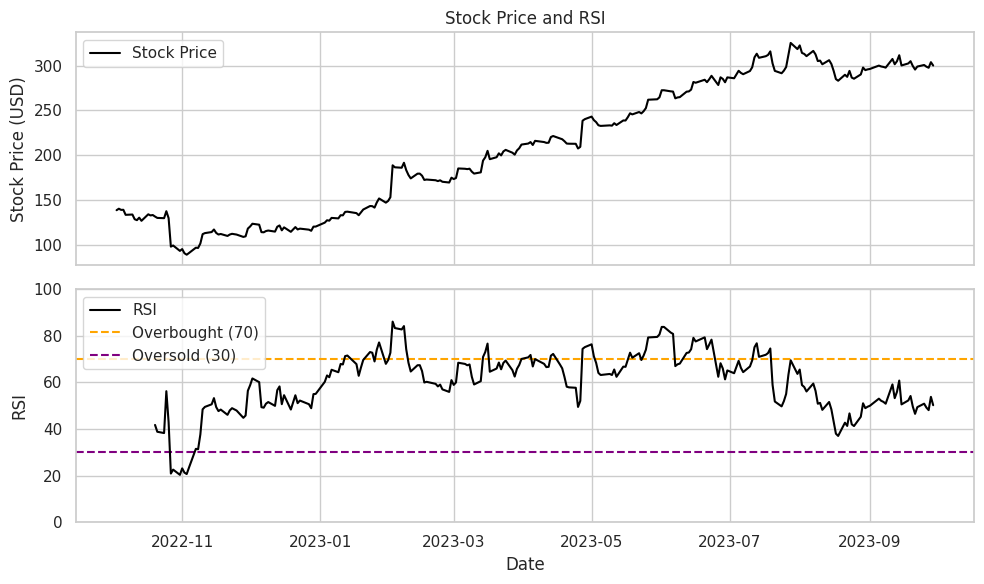

In [19]:
rsi_values = calculate_rsi(close_prices)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

sns.lineplot(
    ax=ax1, x=close_prices.index, y=close_prices, label="Stock Price", color="black"
)
ax1.set_title("Stock Price and RSI")
ax1.set_ylabel("Stock Price (USD)")
ax1.legend(loc="upper left")

sns.lineplot(
    ax=ax2, x=rsi_values.index, y=rsi_values, label="RSI", color="black", zorder=5
)
ax2.axhline(70, linestyle="--", color="orange", label="Overbought (70)")
ax2.axhline(30, linestyle="--", color="purple", label="Oversold (30)")
ax2.set_ylim([0, 100])
ax2.set_ylabel("RSI")
ax2.set_xlabel("Date")

ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

## Profit / Stop Loss


In [20]:
def simulate_macd_trading(
    price_series, fast_period=12, slow_period=26, signal_period=9
):
    macd_df = calculate_macd(price_series, fast_period, slow_period, signal_period)

    macd_df["Signal"] = 0
    initial_period = macd_df.index[fast_period:]
    macd_df.loc[initial_period, "Signal"] = np.where(
        macd_df["MACD_Line"][initial_period] > macd_df["Signal_Line"][initial_period],
        1,
        0,
    )
    macd_df["Position"] = macd_df["Signal"].diff()

    position = False  # Tracks whether we are currently holding the stock
    buy_signals = []
    sell_signals = []
    operations = []
    buy_prices = []

    for date, row in macd_df.iterrows():
        # Accumulate signals
        if row["Position"] == 1:  # A buy signal
            buy_signals.append((date, price_series[date], "Buy Signal"))
        elif row["Position"] == -1:  # A sell signal
            sell_signals.append((date, price_series[date], "Sell Signal"))

        # Prices
        if not position and row["Position"] == 1:
            position = True
            operations.append((date, open_prices[date], "Buy Signal"))
            buy_prices.append(open_prices[date])
        if position:
            if row["Position"] == -1:
                position = False
                operations.append((date, open_prices[date], "Sell Signal"))
            elif shifted_close_prices[date] < 0.95 * buy_prices[-1]:
                position = False
                operations.append((date, open_prices[date], "Stop Loss"))
            elif shifted_close_prices[date] > 1.2 * buy_prices[-1]:
                position = False
                operations.append((date, open_prices[date], "Take Profit"))

    cols = ["Date", "Price", "Signal Type"]
    return (
        pd.DataFrame(buy_signals, columns=cols),
        pd.DataFrame(sell_signals, columns=cols),
        pd.DataFrame(operations, columns=cols),
    )

In [21]:
buy_signals, sell_signals, operations = simulate_macd_trading(close_prices)

initial_investment = 10000
current_cash = initial_investment
stocks_in_hand = 0
interim_values = []

for index, operation in operations.iterrows():
    date, price, signal_type = operation

    if signal_type == "Buy Signal" and current_cash >= price:
        stocks_in_hand = current_cash / price
        interim_values.append(current_cash)
        current_cash = 0
    elif (
        signal_type in ["Sell Signal", "Stop Loss", "Take Profit"]
        and stocks_in_hand > 0
    ):
        current_cash = stocks_in_hand * price
        interim_values.append(current_cash)
        stocks_in_hand = 0

if stocks_in_hand > 0:
    last_price = hist.iloc[-1]["Close"]
    current_cash = stocks_in_hand * last_price
final_value = current_cash

operations["Interim Value"] = interim_values

total_profit = final_value - initial_investment
roi = (total_profit / initial_investment) * 100

print(f"Initial Investment: ${initial_investment:,.2f}")
print(f"Final Value: ${final_value:,.2f}")
print(f"Total Profit/Loss: ${total_profit:,.2f}")
print(f"Return on Investment: {roi:.2f}%")

display(operations)

Initial Investment: $10,000.00
Final Value: $10,782.60
Total Profit/Loss: $782.60
Return on Investment: 7.83%


,Date,Price,Signal Type,Interim Value
0,2022-10-25 00:00:00-04:00,130.880005,Buy Signal,10000.000000
1,2022-10-27 00:00:00-04:00,97.980003,Sell Signal,7486.246921
2,2022-11-10 00:00:00-05:00,107.120003,Buy Signal,7486.246921
3,2022-11-10 00:00:00-05:00,107.120003,Stop Loss,7486.246921
4,2022-12-29 00:00:00-05:00,116.400002,Buy Signal,7486.246921
5,2023-01-24 00:00:00-05:00,141.690002,Take Profit,9112.769163
6,2023-03-15 00:00:00-04:00,192.949997,Buy Signal,9112.769163
7,2023-03-29 00:00:00-04:00,203.559998,Sell Signal,9613.865240
8,2023-03-30 00:00:00-04:00,203.380005,Buy Signal,9613.865240
9,2023-04-11 00:00:00-04:00,215.479996,Sell Signal,10185.837305


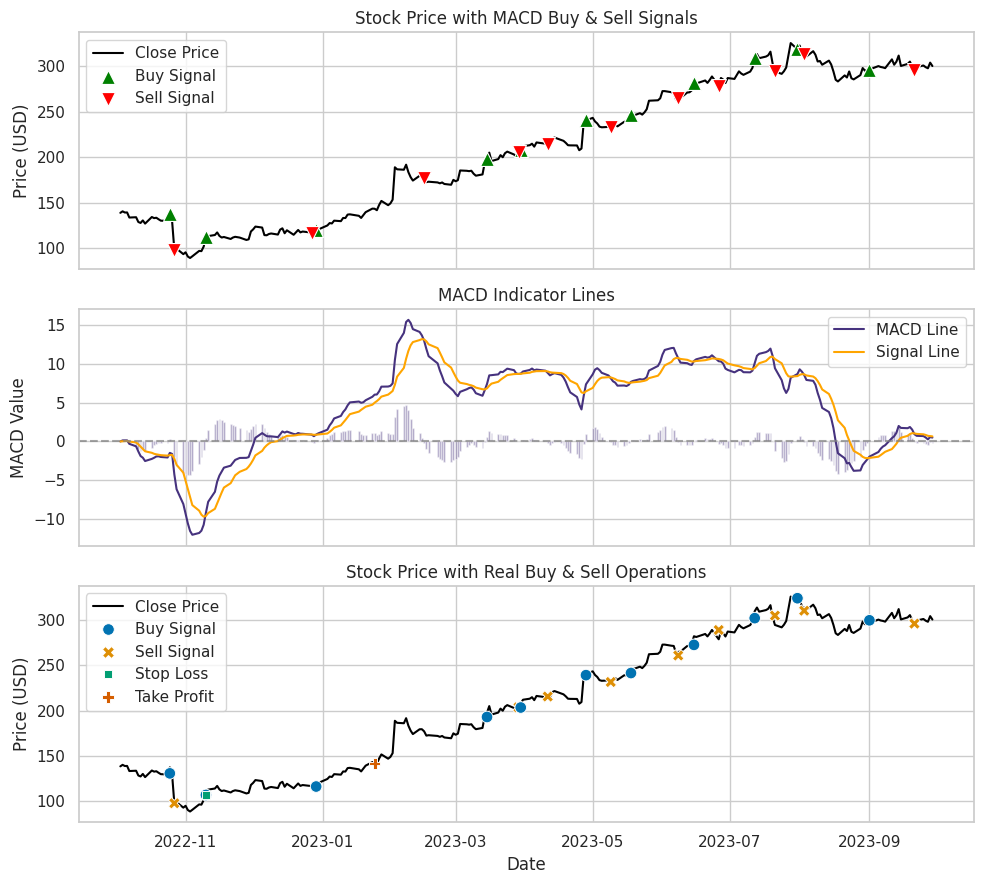

In [22]:
fig, axs = plt.subplots(3, figsize=(10, 9), sharex=True)

# upper plot
sns.lineplot(
    ax=axs[0], x=close_prices.index, y=close_prices, label="Close Price", color="black"
)
sns.scatterplot(
    ax=axs[0],
    x=buy_signals["Date"],
    y=buy_signals["Price"],
    label="Buy Signal",
    marker="^",
    color="green",
    s=100,
    zorder=2,
)
sns.scatterplot(
    ax=axs[0],
    x=sell_signals["Date"],
    y=sell_signals["Price"],
    label="Sell Signal",
    marker="v",
    color="red",
    s=100,
    zorder=2,
)
axs[0].set_title("Stock Price with MACD Buy & Sell Signals")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price (USD)")
axs[0].legend()

# middle plot
macd_result = calculate_macd(close_prices)

sns.lineplot(ax=axs[1], data=macd_result["MACD_Line"], label="MACD Line")
sns.lineplot(
    ax=axs[1], data=macd_result["Signal_Line"], label="Signal Line", color="orange"
)
axs[1].bar(
    macd_result.index, macd_result["MACD_Histogram"], label="MACD Histogram", alpha=0.5
)
axs[1].axhline(0, linestyle="--", alpha=0.7, color="grey")
axs[1].set_title("MACD Indicator Lines")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("MACD Value")

# lower plot
sns.lineplot(
    ax=axs[2], x=close_prices.index, y=close_prices, label="Close Price", color="black"
)
sns.scatterplot(
    ax=axs[2],
    data=operations,
    x="Date",
    y="Price",
    hue="Signal Type",
    style="Signal Type",
    s=70,
    palette="colorblind",
    alpha=1,
    zorder=2,
)
axs[2].set_title("Stock Price with Real Buy & Sell Operations")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Price (USD)")
axs[2].legend()

plt.tight_layout()
plt.show()